# Informed Search: Admissibility

This notebook will investigate the admissibility of priority list heuristics. 

In order for informed methods like A* search to be optimal, it must be admissible: $h(n) \leq h^{*}(n)$. In other words, it must be an optimistic estimate of the path cost. 

One way to design a heuristic satisfying this constraint is to design a heuristic based on a priority list. Priority list methods commit generators in order of marginal cost. Often the operating constraints are ignored initially, and then some heuristic methods are used to fix the resulting schedule. 

In `ts4uc` we have designed a simple heuristic that commits generators in priority list order, ignoring constraints, then calculates the economic dispatch by simply using the cost per MWh when operating at full capacity. This is very fast to compute and mainly serves to reflect the fact that nodes that are closer to the end of the day will have lower 'cost-to-go' (the cost to the end of the day) then earlier nodes. Importantly, this heuristic does not distinguish between heuristics at the same generation. 

In [107]:
from rl4uc.environment import make_env

from ts4uc.tree_search import informed_search
from ts4uc.tree_search.scenarios import get_net_demand_scenarios
from ts4uc.tree_search.algos import *
from ts4uc.tree_search import node
from ts4uc.agents.ac_agent import ACAgent
from ts4uc import helpers

import numpy as np 
import pandas as pd 
import torch
import json

### User Inputs

In [119]:
ENV_PARAMS_FN = '../data/day_ahead/5gen/30min/env_params.json'
TEST_DATA_BASE_FN = '../data/day_ahead/5gen/30min/profile_{}.csv'
HORIZON = 2
BRANCHING_THRESHOLD = 0.05
HEURISTIC_METHOD = 'priority_list'
SEED = 1 
NUM_SCENARIOS = 100
TEST_SAMPLE_SEED = 999
NUM_SAMPLES = 1000
NUM_PERIODS=48

We will redefine the `solve_day_ahead()` function in order to keep track of the heuristic cost and return this at the end of the search. 

We will also redefine our function for testing schedules to keep track of the period-level operating costs.

In [115]:
def solve_day_ahead(env, 
                    horizon, 
                    net_demand_scenarios,
                    tree_search_func=uniform_cost_search, 
                    **params):
    """
    Solve a day rooted at env. 
    
    Return the schedule and the number of branches at the root for each time period. 
    """
    env.reset()
    final_schedule = np.zeros((env.episode_length, env.num_gen))

    root = node.Node(env=env,
            parent=None,
            action=None,
            step_cost=0,
            path_cost=0)
    
    heuristic_costs = []

    for t in range(env.episode_length):
        s = time.time()
        terminal_timestep = min(env.episode_timestep + horizon, env.episode_length-1)
        path, cost = tree_search_func(root, 
                                      terminal_timestep, 
                                      net_demand_scenarios,
                                      **params)
        a_best = path[0]

        print(f"Period {env.episode_timestep+1}", np.array(a_best, dtype=int), round(cost, 2), round(time.time()-s, 2))
        final_schedule[t, :] = a_best
        env.step(a_best, deterministic=True)
        
        c = informed_search.heuristic(child, terminal_timestep - child.state.episode_timestep, heuristic_method)
        
        root = root.children[a_best.tobytes()]
        root.parent, root.path_cost = None, 0

        gc.collect()
    
        heuristic_costs.append(root.heuristic_cost)
        
    return final_schedule, heuristic_costs

def test_schedule(env, schedule, seed=999, num_samples=1000, deterministic=False):
    costs = np.zeros((num_samples, env.episode_length))
    np.random.seed(seed)
    for i in range(num_samples):
        env.reset()
        total_reward = 0 
        for action in schedule:
            action = np.where(np.array(action)>0, 1, 0)
            obs,reward,done = env.step(action, deterministic)
            costs[i, env.episode_timestep] = -reward
    return costs


In [117]:
def calc_heuristic_preds(test_data_fn):
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    # Load parameters
    env_params = json.load(open(ENV_PARAMS_FN))

    # Load profile 
    profile_df = pd.read_csv(test_data_fn)
    profile_df = profile_df[:NUM_PERIODS]

    params = {'horizon': HORIZON,
              'branching_threshold': BRANCHING_THRESHOLD,
              'heuristic_method': HEURISTIC_METHOD}

    # Init env
    env = make_env(mode='test', profiles_df=profile_df, **env_params)

    # Load policy
    policy = None

    # Generate scenarios for demand and wind errors
    scenarios = get_net_demand_scenarios(profile_df, env, NUM_SCENARIOS)

    schedule_result, heuristic_costs = solve_day_ahead(env=env, 
                                                       net_demand_scenarios=scenarios, 
                                                       tree_search_func=rta_star,
                                                       policy=policy,
                                                       **params)

    TEST_SAMPLE_SEED=999
    test_costs = test_schedule(env, schedule_result, TEST_SAMPLE_SEED, NUM_SAMPLES)

    pred = np.array(heuristic_costs[:-1])

    actual = []
    for i in range(1,NUM_PERIODS):
        actual.append(np.cumsum(test_costs, axis=1).T[-(i+1)].mean())
    actual = np.array(actual)
    
    return pd.DataFrame({'pred': pred,
                         'actual': actual})



In [125]:
df_pred_ls = []
for date in ['2019-05-22', '2017-04-07', '2018-05-30']:
    test_data_fn = TEST_DATA_BASE_FN.format(date)
    df_pred_ls.append(calc_heuristic_preds(test_data_fn))
df_pred = pd.concat(df_pred_ls)

Period 0 [1 0 0 0 0] 9866.47 3.28
Period 1 [1 0 0 0 0] 9694.44 2.51
Period 2 [1 0 0 0 0] 9663.18 2.49
Period 3 [1 0 0 0 0] 9720.18 2.53
Period 4 [1 0 0 0 0] 9834.8 2.59
Period 5 [1 0 0 0 1] 9814.82 2.52
Period 6 [1 0 0 0 1] 9705.69 1.7
Period 7 [1 0 0 0 1] 9801.99 2.46
Period 8 [1 0 0 0 1] 9950.33 2.44
Period 9 [1 0 0 0 1] 9850.73 2.14
Period 10 [1 0 0 0 1] 9865.11 2.45
Period 11 [1 0 0 0 1] 10144.55 2.37
Period 12 [1 0 0 0 1] 11123.17 2.53
Period 13 [1 1 0 0 0] 11756.12 1.7
Period 14 [1 1 0 0 0] 11539.19 0.59
Period 15 [1 1 0 0 0] 11380.64 0.74
Period 16 [1 1 0 0 0] 11113.25 0.89
Period 17 [1 1 0 0 0] 11036.31 0.88
Period 18 [1 1 0 0 0] 11007.64 0.83
Period 19 [1 1 0 0 0] 10988.09 0.8
Period 20 [1 1 0 0 0] 10927.87 0.87
Period 21 [1 1 0 0 0] 10795.74 0.87
Period 22 [1 1 0 0 0] 10669.04 1.63
Period 23 [1 1 0 0 0] 10575.54 2.02
Period 24 [1 1 0 0 0] 10356.98 1.93
Period 25 [1 1 0 0 0] 10229.37 2.08
Period 26 [1 1 0 0 0] 10416.09 2.08
Period 27 [1 1 0 0 0] 10448.6 2.24
Period 28 [1 1 0 0

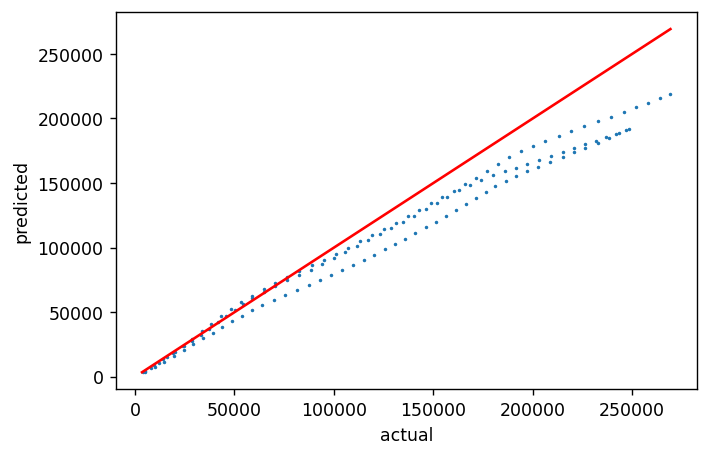

In [130]:
import matplotlib.pyplot as plt

xmin = np.min(df_pred.pred)
xmax = np.max(df_pred.actual)
xmin_to_xmax = np.linspace(xmin, xmax)

fig, ax = plt.subplots(dpi=125)
ax.plot(xmin_to_xmax, xmin_to_xmax, c='r')
ax.scatter(df_pred.actual, df_pred.pred, s=1)
ax.set_xlabel('actual')
ax.set_ylabel('predicted')
plt.show()

,pred,actual
0,192109.485625,248225.387817
1,188408.285617,243296.098964
2,184764.365933,238116.163618
3,181103.121362,232632.054169
4,177389.580122,226410.439812
...,...,...
42,19453.799746,20288.332968
43,15203.650325,16161.734550
44,10966.321470,12069.464372
45,7135.062805,8209.771870


In [134]:
df_pred[df_pred.pred > df_pred.actual]

,pred,actual
32,77351.504262,76345.810502
33,72751.853875,70310.356936
34,67894.214513,64616.763919
35,62842.287687,58696.400102
36,57614.034902,53254.637414
37,52217.320534,48186.860009
38,46705.800977,43239.256661
39,41083.029878,38308.600084
40,35280.549786,33569.047033
41,29549.221234,28813.462129
